In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

import sklearn 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from scipy.stats import chi2_contingency, chi2
print("sklearn version:", sklearn.__version__)


sklearn version: 1.8.0


In [3]:
df_full = pd.read_csv('data.csv')
df_full.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
df_full.head()[['MSRP', 'Make', 'Year', 'Engine Fuel Type', 'Engine HP', 'city mpg' ]].to_latex('Minh_hoa.tex', index=True)

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

MÔ HÌNH HỒI QUY BỘI NHẰM XEM MỐI QUAN HỆ GIỮA BIẾN "MSRP" VÀ CÁC BIẾN ĐỘC LẬP KHÁC.
CHÍNH VÌ VẬY, TA ĐI KIỂM TRA PHÂN PHỐI CỦA BIẾN PHỤ THUỘC 

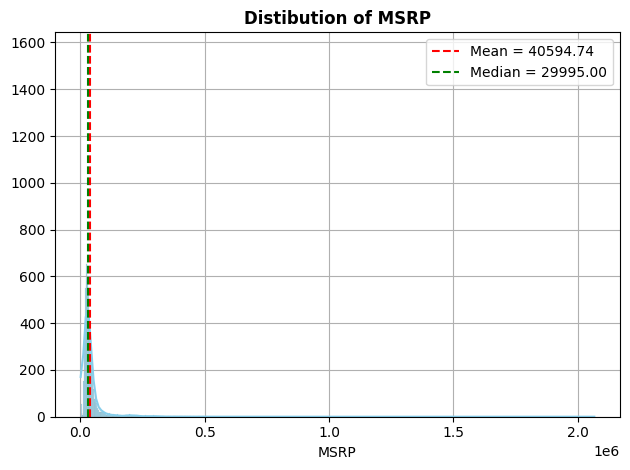

In [6]:
iqr = df_full['MSRP'].quantile(0.75) - df_full['MSRP'].quantile(0.25)
bin_width = 2 * iqr / (len(df_full['MSRP']) ** (1/3))
bins = int((df_full['MSRP'].max() - df_full['MSRP'].min()) / bin_width)

sns.histplot(df_full['MSRP'], kde=True, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(df_full['MSRP'].mean(), color='red', linestyle='--', label=f'Mean = {df_full['MSRP'].mean():.2f}')
plt.axvline(df_full['MSRP'].median(), color='green', linestyle='--', label=f'Median = {df_full['MSRP'].median():.2f}')
plt.title(f'Distibution of MSRP', fontsize=12, fontweight='bold')
plt.legend()
plt.xlabel('MSRP')
plt.ylabel('')
plt.grid()

plt.tight_layout()
    #plt.savefig('quantitative_variable_distributions.png', dpi=400, bbox_inches='tight') 
plt.show()

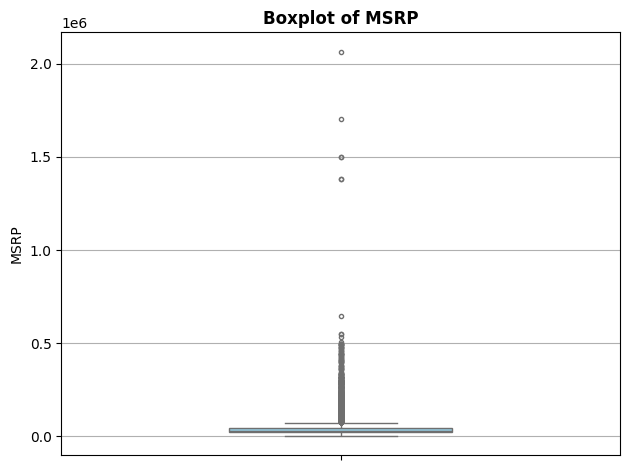

In [7]:
sns.boxplot(
        y=df_full['MSRP'],
        color='skyblue',
        width=0.4,
        fliersize=3   # kích thước điểm outlier
    )
plt.title(f'Boxplot of MSRP', fontsize=12, fontweight='bold')
plt.ylabel(df_full['MSRP'].name)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

MSRP: Phân phối lệch phải với một số giá trị ngoại lai rất cao. Những giá trị này có thể đại diện cho các mẫu xe sang trọng hoặc hiệu suất cao.
Chính vì vậy, để tránh mô hình hồi quy tuyến tính bị kéo lệch, ta lấy log(MSRP).

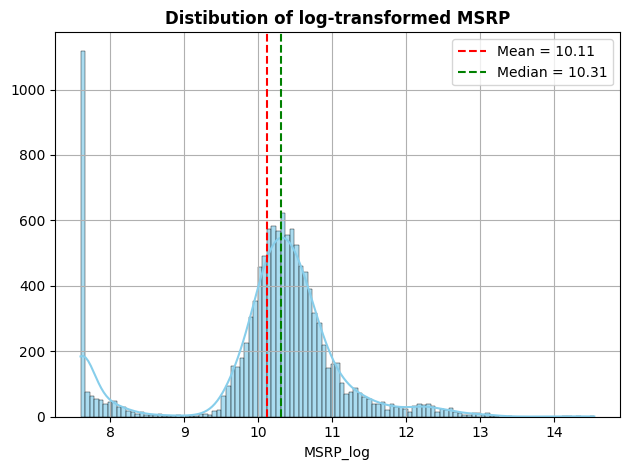

In [8]:
df_full['MSRP_log'] = np.log1p(df_full['MSRP'])

iqr = df_full['MSRP_log'].quantile(0.75) - df_full['MSRP_log'].quantile(0.25)
bin_width = 2 * iqr / (len(df_full['MSRP_log']) ** (1/3))
bins = int((df_full['MSRP_log'].max() - df_full['MSRP_log'].min()) / bin_width)


sns.histplot(df_full['MSRP_log'], kde=True, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(df_full['MSRP_log'].mean(), color='red', linestyle='--', label=f'Mean = {df_full["MSRP_log"].mean():.2f}')
plt.axvline(df_full['MSRP_log'].median(), color='green', linestyle='--', label=f'Median = {df_full["MSRP_log"].median():.2f}')
plt.title(f'Distibution of log-transformed MSRP', fontsize=12, fontweight='bold')
plt.legend()
plt.xlabel(df_full['MSRP_log'].name)
plt.ylabel('')
plt.grid()
plt.tight_layout()
plt.show()

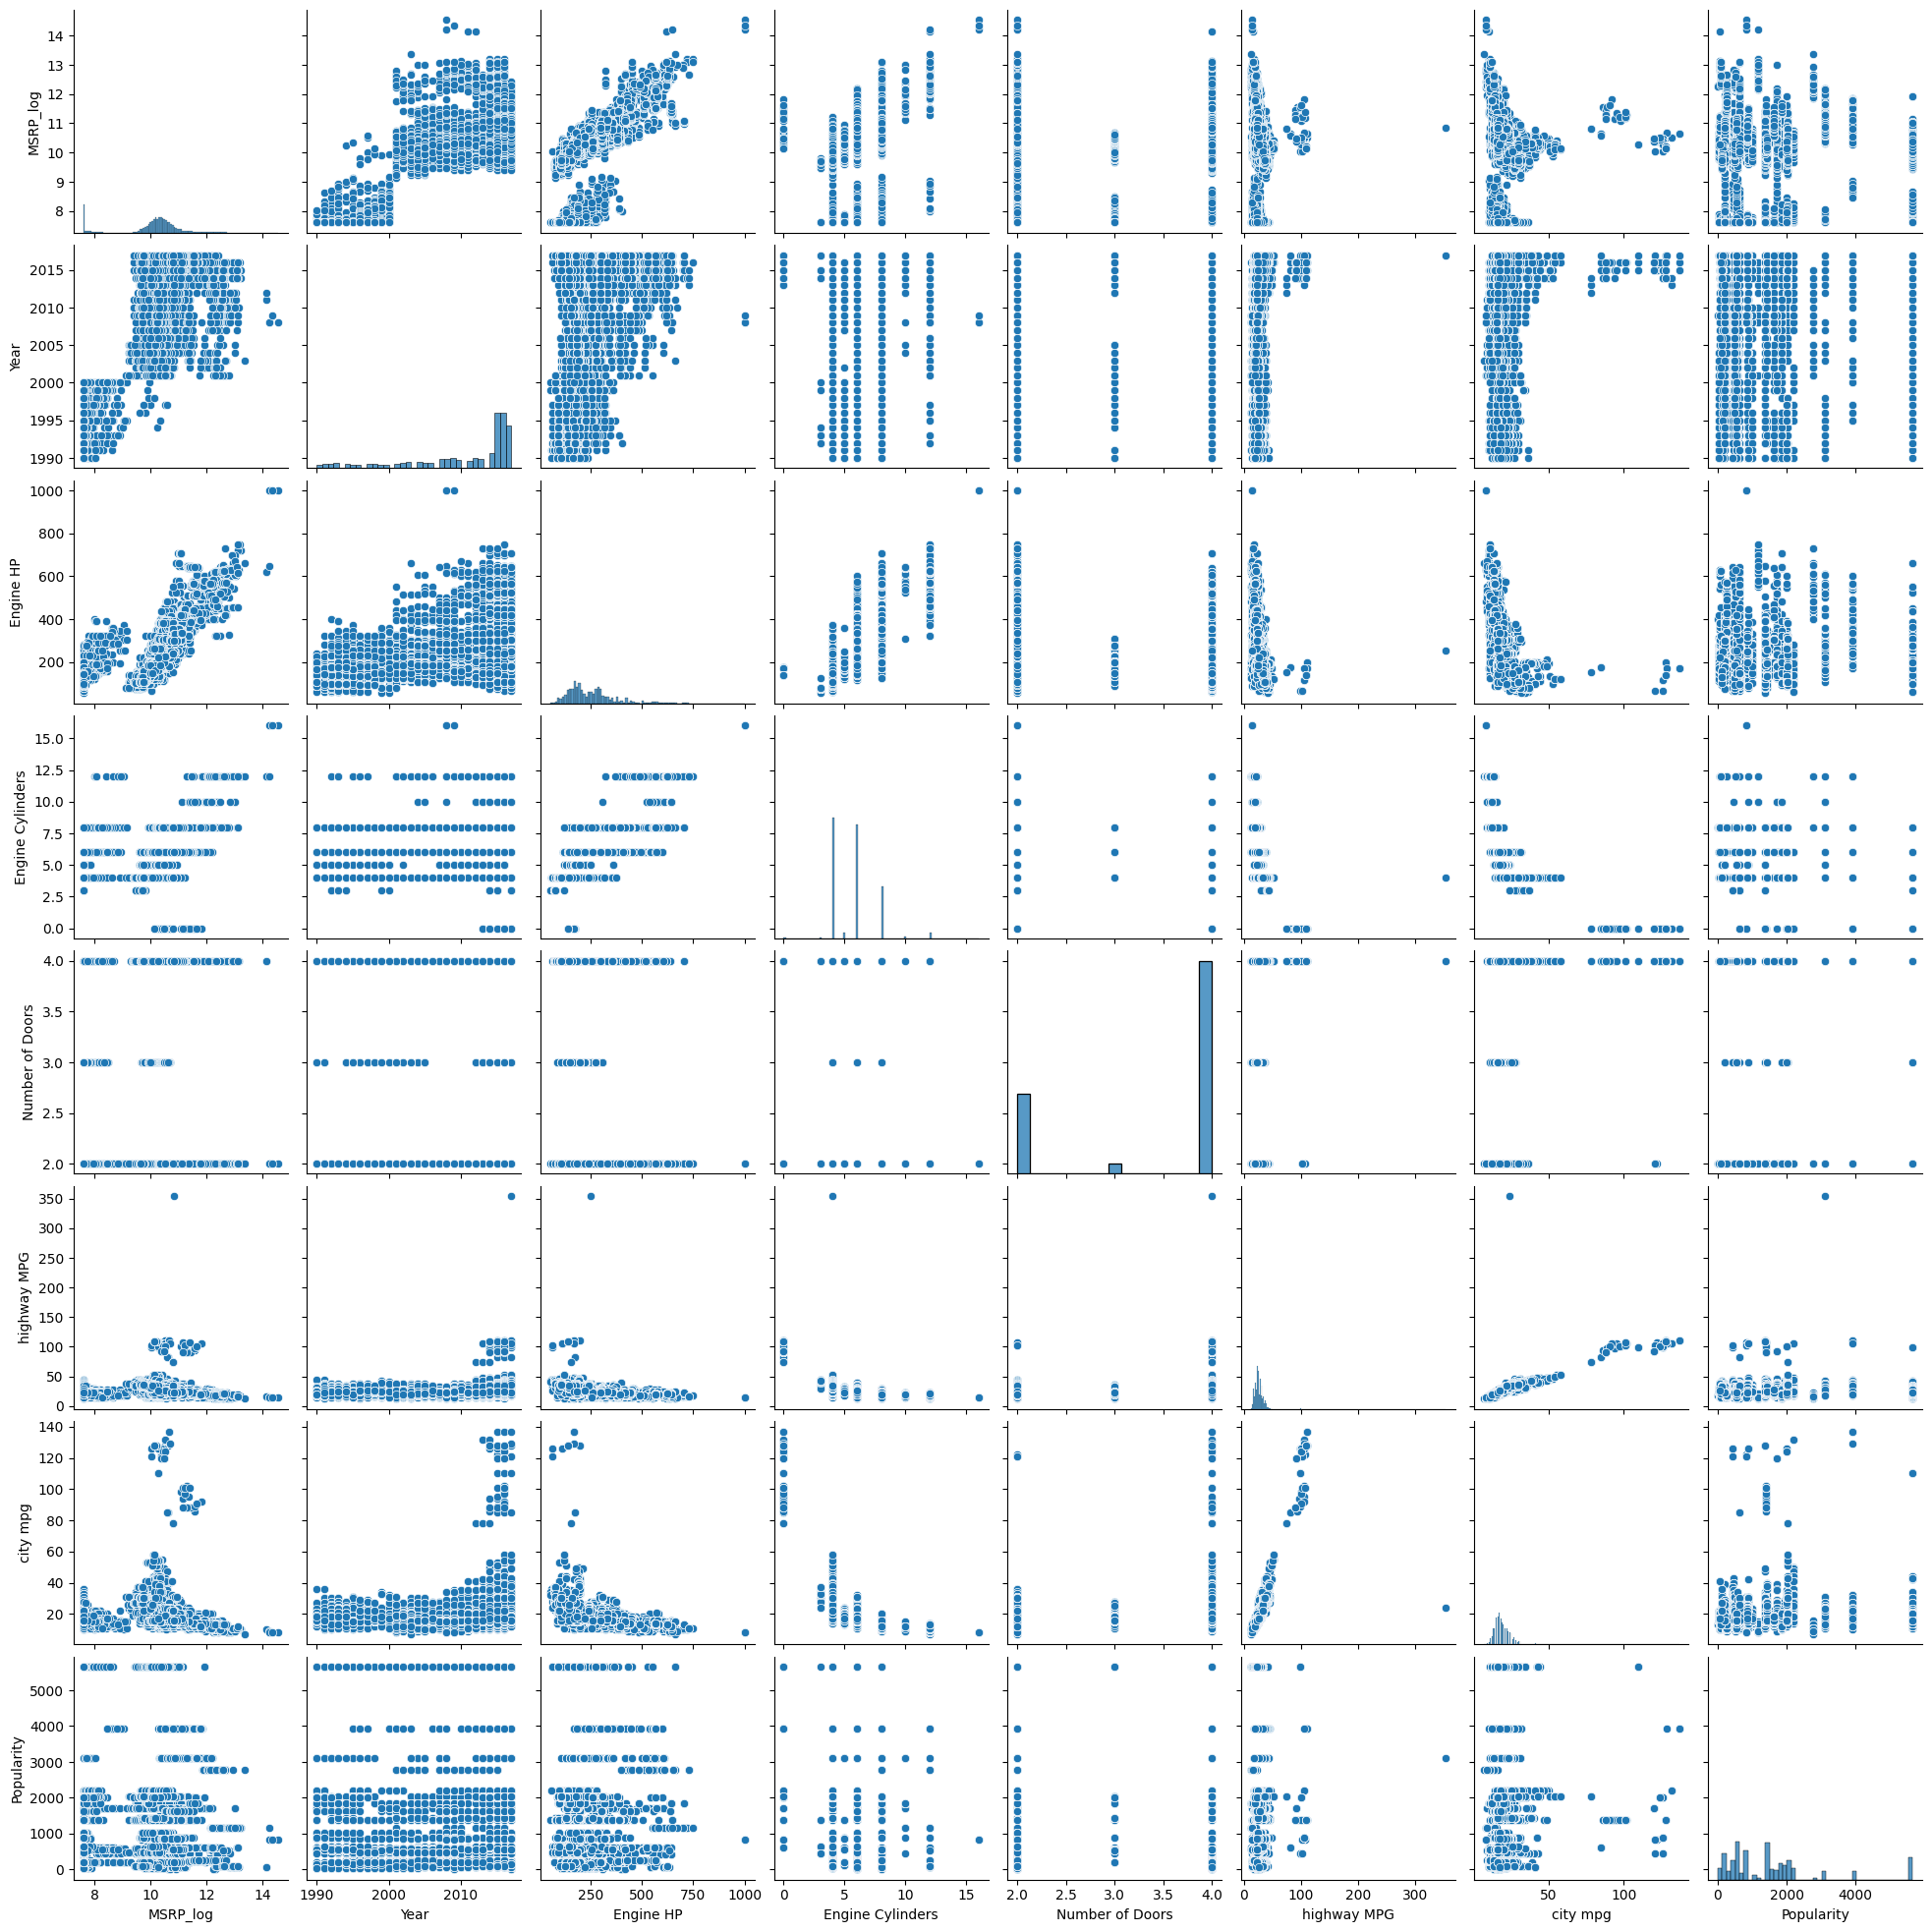

In [9]:
sns.pairplot(df_full[['MSRP_log', 'Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']])

In [10]:
df = df_full[['MSRP', 'Make', 'Year', 'Engine Fuel Type', 'Engine HP', 'city mpg']]
df.head()

,MSRP,Make,Year,Engine Fuel Type,Engine HP,city mpg
0,46135,BMW,2011,premium unleaded (required),335.0,19
1,40650,BMW,2011,premium unleaded (required),300.0,19
2,36350,BMW,2011,premium unleaded (required),300.0,20
3,29450,BMW,2011,premium unleaded (required),230.0,18
4,34500,BMW,2011,premium unleaded (required),230.0,18


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSRP,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0
Year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
Engine HP,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
city mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0


XỬ LÝ GIÁ TRỊ THIẾU

In [12]:
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ["column", "missing_count"]
missing_data['missing_pct'] = (missing_data["missing_count"] / len(df)) * 100
missing_data

fig = px.bar(missing_data, x="column", y="missing_pct", title="Percentage of Missing Values per Column",
             labels={"missing_pct": "Percent Missing", "column": "Column"},
             text="missing_pct")
fig.update_traces(texttemplate="%{text:.1f}%", textposition="outside")
fig.update_layout(yaxis_range=[0, 100])
fig.show()

In [13]:
df[df["Engine Fuel Type"].isnull()]

,MSRP,Make,Year,Engine Fuel Type,Engine HP,city mpg
11321,17199,Suzuki,2004,NaN,155.0,17
11322,20199,Suzuki,2004,NaN,155.0,17
11323,18499,Suzuki,2004,NaN,155.0,17


In [14]:
df.loc[df["Engine Fuel Type"].isna(), 'Engine Fuel Type'] = 'regular unleaded'

In [15]:
# Fill missing horsepower values with info from edmunds.com and MotorTrend (part 1)
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "500e"), "Engine HP"] = 111
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Continental") & (df["Make"] == "Lincoln") & (df["Engine Fuel Type"] == "premium unleaded (recommended)") & (df["Year"] == 2017), "Engine HP"] = 400
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Continental") & (df["Make"] == "Lincoln") & (df["Engine Fuel Type"] == "premium unleaded (recommended)") & (df["Year"] == 2017), "Engine HP"] = 335
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Escape") & (df["Make"] == "Ford") & (df_full["Driven_Wheels"] == "front wheel drive") & (df["Engine Fuel Type"] == "regular unleaded"), "Engine HP"] = 168
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Escape") & (df["Make"] == "Ford") & (df_full["Driven_Wheels"] == "all wheel drive") & (df["Engine Fuel Type"] == "regular unleaded"), "Engine HP"] = 178
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Fit EV") & (df["Make"] == "Honda"), "Engine HP"] = 123
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Focus") & (df["Make"] == "Ford") & (df["Engine Fuel Type"] == "electric"), "Engine HP"] = 143
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Freestar") & (df["Make"] == "Ford") & (df["Year"] == 2005), "Engine HP"] = 193
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "i-MiEV") & (df["Year"] == 2014), "Engine HP"] = 66
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Impala") & (df["Make"] == "Chevrolet") & (df["Engine Fuel Type"] == "flex-fuel (unleaded/natural gas)"), "Engine HP"] = 260
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "Leaf") & (df["Make"] == "Nissan"), "Engine HP"] = 107
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "M-Class") & (df["Make"] == "Mercedes-Benz") & (df["Year"] == 2015) & (df["Engine Fuel Type"] == "diesel"), "Engine HP"] = 254
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "MKZ") & (df["Make"] == "Lincoln") & (df["Year"] == 2017) & (df["Engine Fuel Type"] == "regular unleaded"), "Engine HP"] = 245
df.loc[(df["Engine HP"].isna()) & (df_full["Model"] == "RAV4 EV") & (df["Make"] == "Toyota") & (df["Year"].isin([2013, 2014])), "Engine HP"] = 154
df.loc[(df_full["Model"] == "Soul EV") & (df["Make"] == "Kia"), "Engine HP"] = 109


In [16]:
# Fill missing horsepower values using publicly available info (part 2)
updates = {
    6921: {'Engine HP': 362},
    6924: {'Engine HP': 422},
    6923: {'Engine HP': 691},
    6922: {'Engine HP': 380},
    6925: {'Engine HP': 380},
    6926: {'Engine HP': 328},
    6927: {'Engine HP': 417},
    6928: {'Engine HP': 762},
    6929: {'Engine HP': 373},
    6930: {'Engine HP': 328},
    6931: {'Engine HP': 315},
    6932: {'Engine HP': 463},
    6933: {'Engine HP': 315},
    6934: {'Engine HP': 328},
    6935: {'Engine HP': 328},
    6936: {'Engine HP': 417, 'city mpg': 95},
    6937: {'Engine HP': 463}, 
    6938: {'Engine HP': 373}
}

# Áp dụng cập nhật
for idx, vals in updates.items():
    for col, val in vals.items():
        df.loc[idx, col] = val


In [17]:
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ["column", "missing_count"]
missing_data['missing_pct'] = (missing_data["missing_count"] / len(df)) * 100
missing_data

fig = px.bar(missing_data, x="column", y="missing_pct", title="Percentage of Missing Values per Column",
             labels={"missing_pct": "Percent Missing", "column": "Column"},
             text="missing_pct")
fig.update_traces(texttemplate="%{text:.1f}%", textposition="outside")
fig.update_layout(yaxis_range=[0, 100])
fig.show()

In [18]:
df['powertrain'] = 'ICE'
# Gán cho Hybrid trước (vì có thể có xe Hybrid vẫn chạy xăng)
df.loc[df_full['Market Category'].str.contains('Hybrid', case=False, na=False), 'powertrain'] = 'Hybrid'

# Gán cho EV sau cùng để đảm bảo độ ưu tiên cao nhất cho xe điện thuần túy
df.loc[df['Engine Fuel Type'] == 'electric', 'powertrain'] = 'EV'

C:\Users\Admin\AppData\Local\Temp\ipykernel_10368\246087924.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
print(df['powertrain'].value_counts())

powertrain
ICE       11501
Hybrid      347
EV           66
Name: count, dtype: int64


Dữ liệu đã tổng hợp:
   Year powertrain  count
0  1990        ICE    123
1  1991        ICE    152
2  1992        ICE    177
3  1993        ICE    209
4  1994        ICE    163

Kích thước: (46, 3)


<Figure size 1200x700 with 0 Axes>

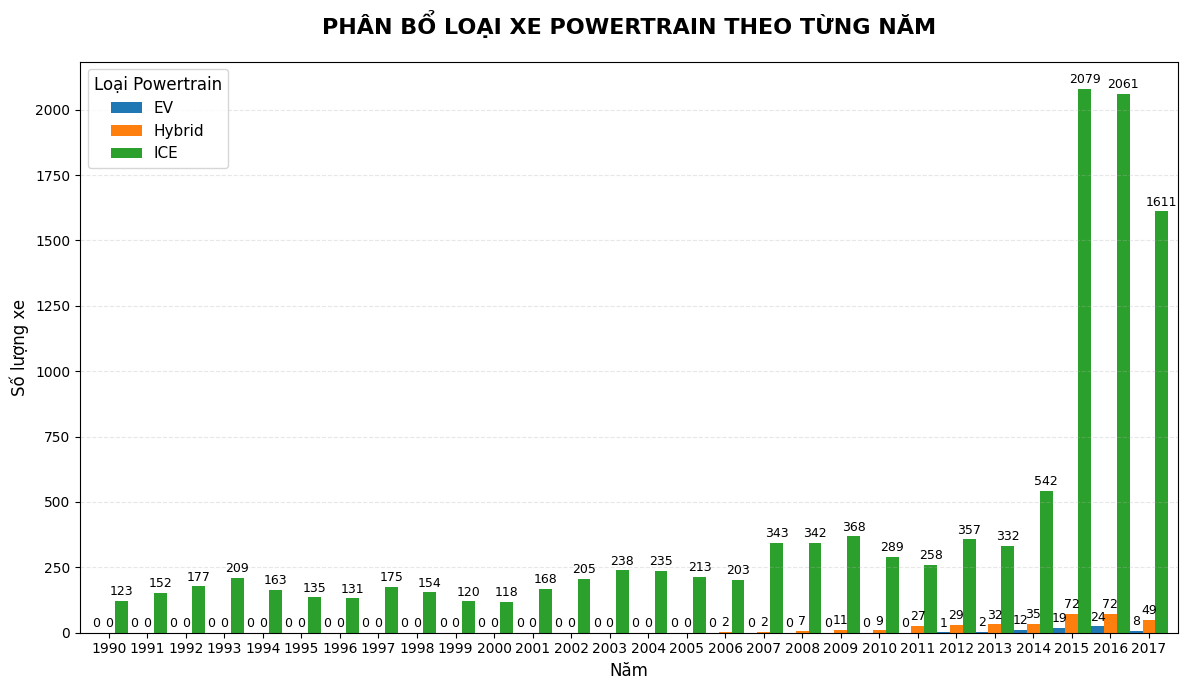

In [20]:
# Bước 1: Tạo DataFrame tổng hợp
df_summary = df.groupby(['Year', 'powertrain']).size().reset_index(name='count')

print("Dữ liệu đã tổng hợp:")
print(df_summary.head())
print(f"\nKích thước: {df_summary.shape}")

# Bước 2: Vẽ biểu đồ với pivot
plt.figure(figsize=(12, 7))

df_pivot = df_summary.pivot(index='Year', columns='powertrain', values='count')

# Vẽ biểu đồ
ax = df_pivot.plot(kind='bar', width=1, figsize=(12, 7))

# Tùy chỉnh
plt.title('PHÂN BỔ LOẠI XE POWERTRAIN THEO TỪNG NĂM', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng xe', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Loại Powertrain', title_fontsize=12, fontsize=11)

# Thêm giá trị trên mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9, padding=2)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Dữ liệu đã tổng hợp:
   Year powertrain  count
0  2010     Hybrid      9
1  2010        ICE    289
2  2011     Hybrid     27
3  2011        ICE    258
4  2012         EV      1

Kích thước: (22, 3)


<Figure size 1200x700 with 0 Axes>

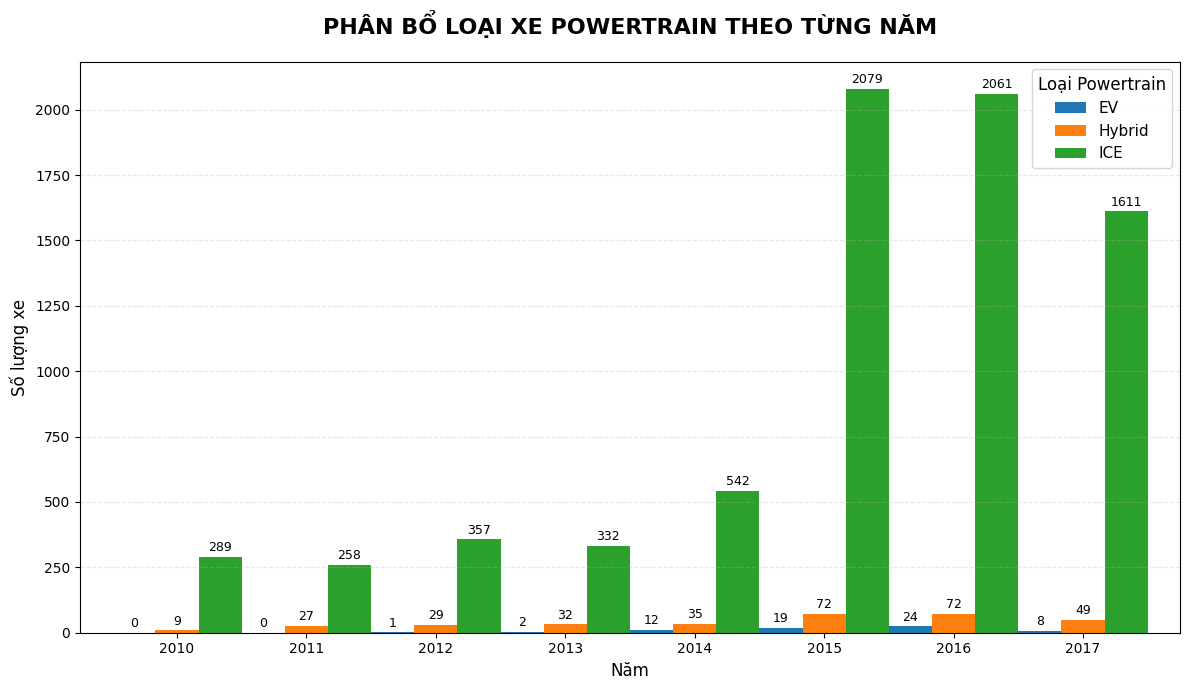

In [21]:
df = df[df['Year'] >= 2010]
# Bước 1: Tạo DataFrame tổng hợp
df_summary = df.groupby(['Year', 'powertrain']).size().reset_index(name='count')

print("Dữ liệu đã tổng hợp:")
print(df_summary.head())
print(f"\nKích thước: {df_summary.shape}")

# Bước 2: Vẽ biểu đồ với pivot
plt.figure(figsize=(12, 7))

df_pivot = df_summary.pivot(index='Year', columns='powertrain', values='count')

# Vẽ biểu đồ
ax = df_pivot.plot(kind='bar', width=1, figsize=(12, 7))

# Tùy chỉnh
plt.title('PHÂN BỔ LOẠI XE POWERTRAIN THEO TỪNG NĂM', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng xe', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Loại Powertrain', title_fontsize=12, fontsize=11)

# Thêm giá trị trên mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9, padding=2)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [22]:
df_electric = pd.read_csv('Electric_Vehicle_Population_Data.csv')
df_electric.head()

,Year,Make,Model,Electric Vehicle Type,MSRP,powertrain
0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),31950,EV
1,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),69900,EV
2,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),69900,EV
3,2019,VOLVO,XC60,Plug-in Hybrid Electric Vehicle (PHEV),52900,Hybrid
4,2018,KIA,SOUL EV,Battery Electric Vehicle (BEV),33950,EV


In [23]:
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   3393 non-null   int64 
 1   Make                   3393 non-null   object
 2   Model                  3393 non-null   object
 3   Electric Vehicle Type  3393 non-null   object
 4   MSRP                   3393 non-null   int64 
 5   powertrain             3393 non-null   object
dtypes: int64(2), object(4)
memory usage: 159.2+ KB


In [24]:
df_electric.duplicated(subset=["Make", "Model", "Year"])
df_electric = df_electric.drop_duplicates(subset=["Make", "Model", "Year"])

In [25]:
df_electric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 0 to 1929
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   31 non-null     int64 
 1   Make                   31 non-null     object
 2   Model                  31 non-null     object
 3   Electric Vehicle Type  31 non-null     object
 4   MSRP                   31 non-null     int64 
 5   powertrain             31 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.7+ KB


In [26]:
df_electric.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,31.0,2016.161290,3.246503,2008.0,2014.5,2018.0,2018.0,2020.0
MSRP,31.0,91763.709677,143590.452015,31950.0,41847.5,59900.0,89900.0,845000.0


In [27]:
#ndf_electric.to_csv("EV_Hybrid.csv", index=False)

In [28]:
df_ev = pd.read_csv("EV_Hybrid.csv")
df_ev.head()

,Year,Make,Model,Electric Vehicle Type,MSRP,powertrain,Engine HP
0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),31950,EV,109
1,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),69900,EV,416
2,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),69900,EV,362
3,2019,VOLVO,XC60,Plug-in Hybrid Electric Vehicle (PHEV),52900,Hybrid,400
4,2018,KIA,SOUL EV,Battery Electric Vehicle (BEV),33950,EV,109


In [29]:

cols = ['MSRP', 'Make', 'Year', 'Engine HP','powertrain']

df_main_sub = df[cols]
df_ev_sub   = df_ev[cols]

# gộp theo Make + Year
df_merged = pd.concat([df_main_sub, df_ev_sub], axis=0, ignore_index=True)


In [30]:
df_merged.head()

,MSRP,Make,Year,Engine HP,powertrain
0,46135,BMW,2011,335.0,ICE
1,40650,BMW,2011,300.0,ICE
2,36350,BMW,2011,300.0,ICE
3,29450,BMW,2011,230.0,ICE
4,34500,BMW,2011,230.0,ICE


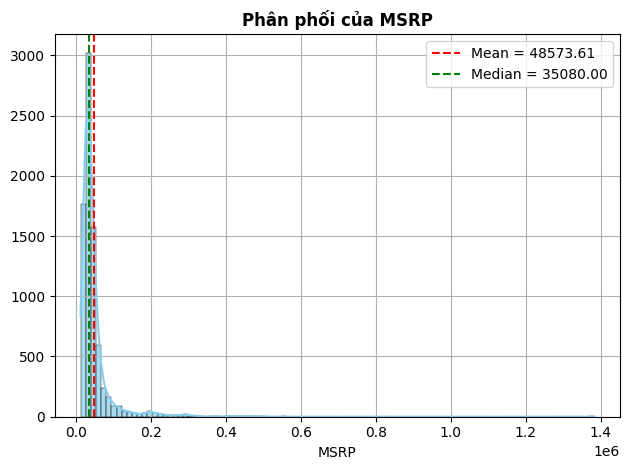

In [31]:
iqr = df_merged['MSRP'].quantile(0.75) - df_merged['MSRP'].quantile(0.25)
bin_width = 2 * iqr / (len(df_merged['MSRP']) ** (1/3))
bins = int((df_merged['MSRP'].max() - df_merged['MSRP'].min()) / bin_width)

sns.histplot(df_merged['MSRP'], kde=True, bins=100, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(df_merged['MSRP'].mean(), color='red', linestyle='--', label=f'Mean = {df_merged['MSRP'].mean():.2f}')
plt.axvline(df_merged['MSRP'].median(), color='green', linestyle='--', label=f'Median = {df_merged['MSRP'].median():.2f}')
plt.title(f'Phân phối của MSRP', fontsize=12, fontweight='bold')
plt.legend()
plt.xlabel('MSRP')
plt.ylabel('')
plt.grid()

plt.tight_layout()
    #plt.savefig('quantitative_variable_distributions.png', dpi=400, bbox_inches='tight') 
plt.show()



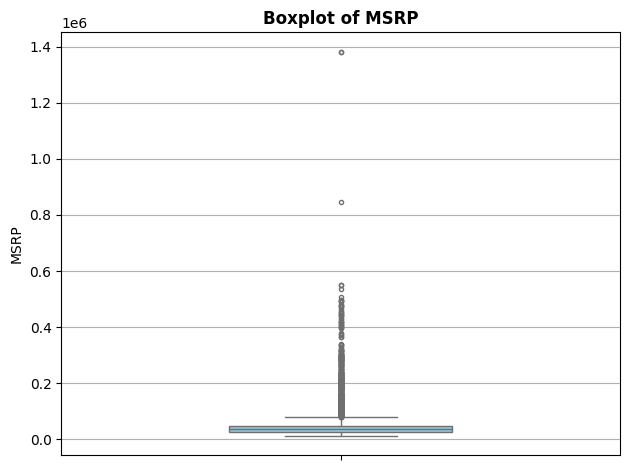

In [32]:
sns.boxplot(
        y=df_merged['MSRP'],
        color='skyblue',
        width=0.4,
        fliersize=3   # kích thước điểm outlier
    )
plt.title(f'Boxplot of MSRP', fontsize=12, fontweight='bold')
plt.ylabel(df_full['MSRP'].name)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

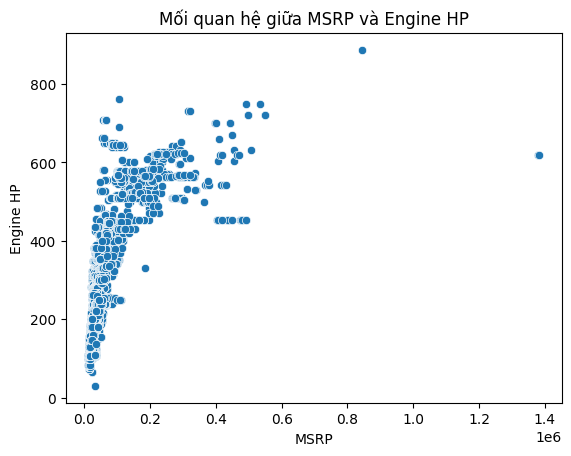

In [33]:
sns.scatterplot(
    data=df_merged,
    y="Engine HP",
    x="MSRP"
)

plt.title("Mối quan hệ giữa MSRP và Engine HP")
plt.show()

In [34]:
df_merged['MSRP_log'] = np.log(df_merged['MSRP'])

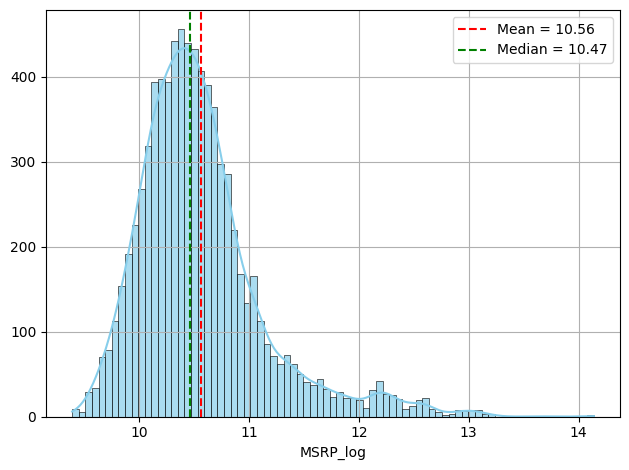

In [35]:
iqr = df_merged['MSRP_log'].quantile(0.75) - df_merged['MSRP_log'].quantile(0.25)
bin_width = 2 * iqr / (len(df_merged['MSRP']) ** (1/3))
bins = int((df_merged['MSRP_log'].max() - df_merged['MSRP_log'].min()) / bin_width)

sns.histplot(df_merged['MSRP_log'], kde=True, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(df_merged['MSRP_log'].mean(), color='red', linestyle='--', label=f'Mean = {df_merged['MSRP_log'].mean():.2f}')
plt.axvline(df_merged['MSRP_log'].median(), color='green', linestyle='--', label=f'Median = {df_merged['MSRP_log'].median():.2f}')
plt.title('')
plt.legend()
plt.xlabel('MSRP_log')
plt.ylabel('')
plt.grid()

plt.tight_layout()
    #plt.savefig('quantitative_variable_distributions.png', dpi=400, bbox_inches='tight') 
plt.show()



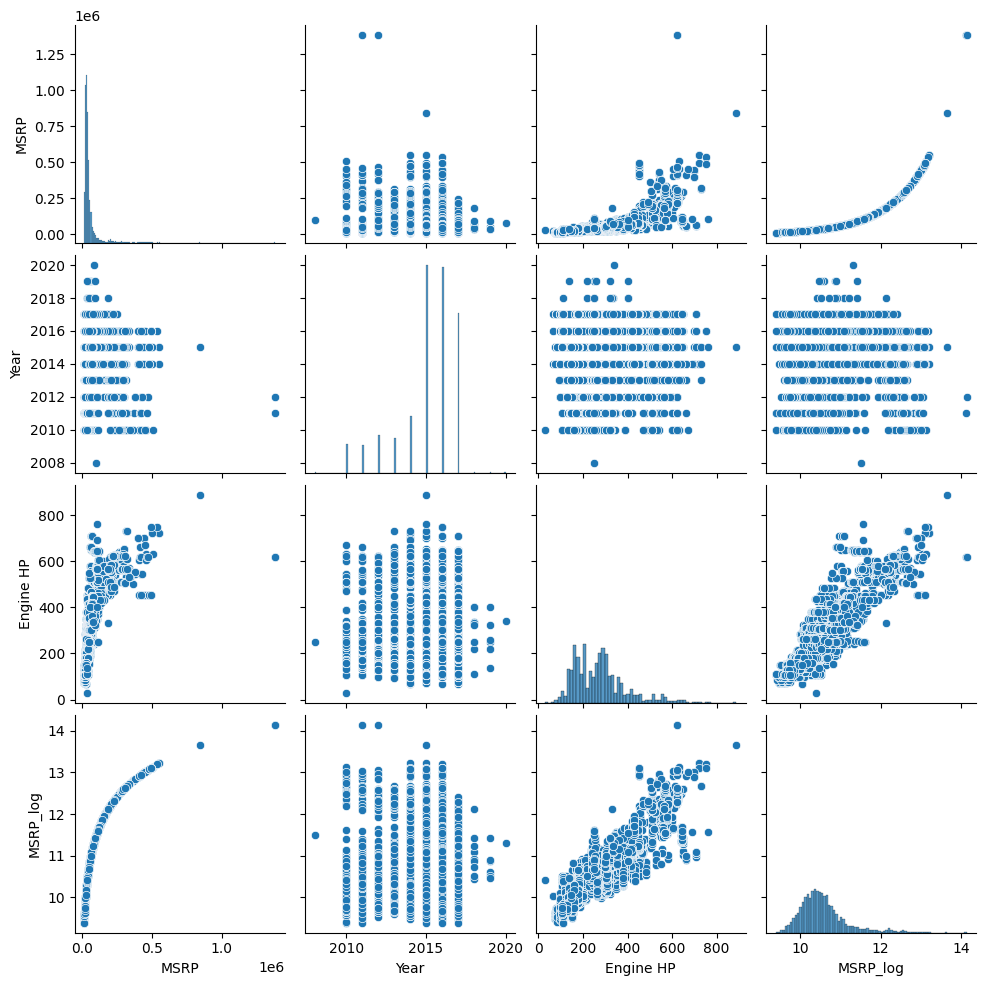

In [36]:

sns.pairplot(df_merged)

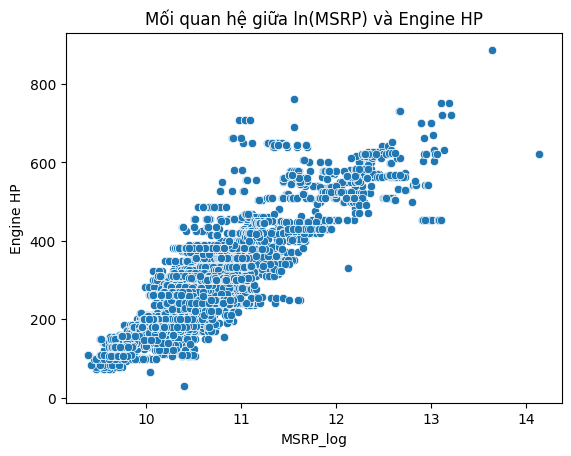

In [37]:
sns.scatterplot(
    data=df_merged,
    y="Engine HP",
    x="MSRP_log"
)

plt.title("Mối quan hệ giữa ln(MSRP) và Engine HP")
plt.show()

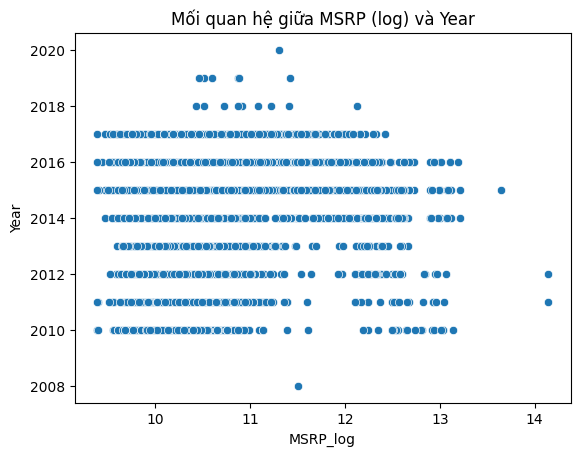

In [38]:
sns.scatterplot(
    data=df_merged,
    y="Year",
    x="MSRP_log"
)

plt.title("Mối quan hệ giữa MSRP (log) và Year")
plt.show()

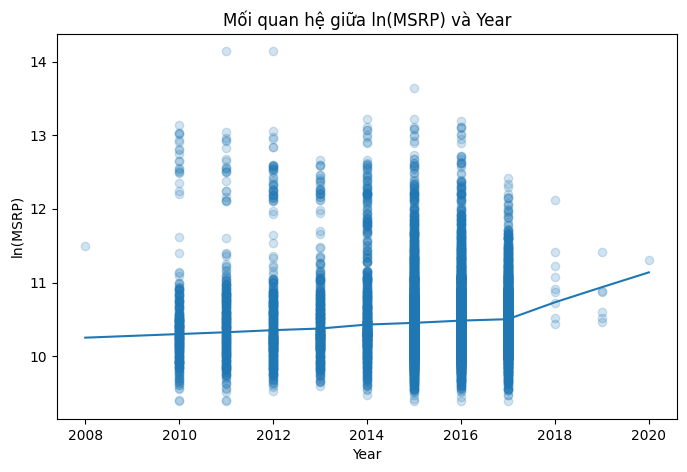

In [39]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    df_merged["Year"],
    df_merged["MSRP_log"],
    alpha=0.2
)

# LOWESS smoothing
lowess = sm.nonparametric.lowess(
    df_merged["MSRP_log"],
    df_merged["Year"],
    frac=0.3
)

plt.plot(lowess[:, 0], lowess[:, 1])
plt.xlabel("Year")
plt.ylabel("ln(MSRP)")
plt.title("Mối quan hệ giữa ln(MSRP) và Year")
plt.show()


In [40]:
cor_matrix = df_merged[['MSRP_log', 'Year', 'Engine HP']].corr()
fig = px.imshow(
    cor_matrix,
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    width=500, height=500
)   
fig.show()

Dữ liệu đã tổng hợp:
   Year powertrain  count
0  2008         EV      1
1  2010         EV      1
2  2010     Hybrid     10
3  2010        ICE    289
4  2011         EV      1

Kích thước: (29, 3)


<Figure size 1200x700 with 0 Axes>

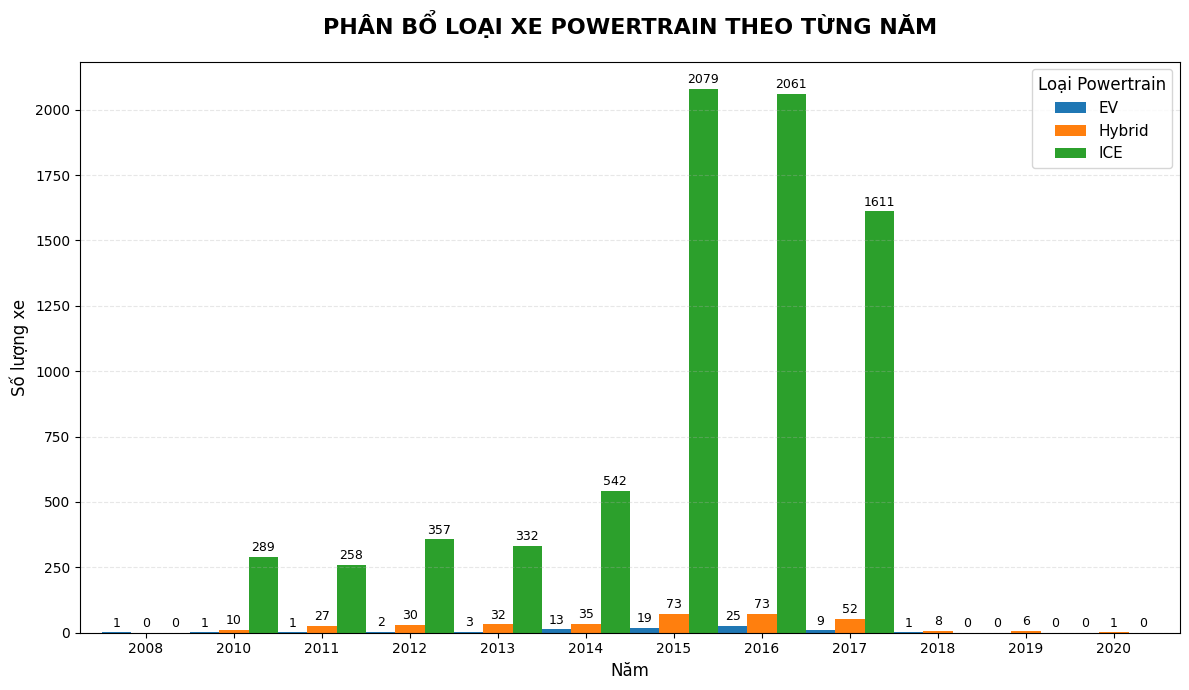

In [41]:
# Bước 1: Tạo DataFrame tổng hợp
df_summary = df_merged.groupby(['Year', 'powertrain']).size().reset_index(name='count')

print("Dữ liệu đã tổng hợp:")
print(df_summary.head())
print(f"\nKích thước: {df_summary.shape}")

# Bước 2: Vẽ biểu đồ với pivot
plt.figure(figsize=(12, 7))

df_pivot = df_summary.pivot(index='Year', columns='powertrain', values='count')

# Vẽ biểu đồ
ax = df_pivot.plot(kind='bar', width=1, figsize=(12, 7))

# Tùy chỉnh
plt.title('PHÂN BỔ LOẠI XE POWERTRAIN THEO TỪNG NĂM', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng xe', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Loại Powertrain', title_fontsize=12, fontsize=11)

# Thêm giá trị trên mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9, padding=2)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [42]:
df_merged["EV"] = (df_merged["powertrain"] == "EV").astype(int)
df_merged["Hybrid"] = (df_merged["powertrain"] == "Hybrid").astype(int)
# kiểm tra biến powertrain
df_merged[["powertrain", "EV", "Hybrid"]].head()


,powertrain,EV,Hybrid
0,ICE,0,0
1,ICE,0,0
2,ICE,0,0
3,ICE,0,0
4,ICE,0,0


In [43]:
df_merged['Make'].value_counts()


Make
Volkswagen              686
Chevrolet               671
Toyota                  597
Ford                    536
Nissan                  451
Honda                   390
Cadillac                338
BMW                     313
GMC                     292
Audi                    272
Mercedes-Benz           265
Dodge                   256
Hyundai                 250
Infiniti                236
Mazda                   230
Subaru                  181
Volvo                   177
Acura                   174
Kia                     173
Lexus                   140
Mitsubishi              130
Porsche                 120
Buick                   120
Land Rover              115
Lincoln                 112
Suzuki                  106
Aston Martin             85
Chrysler                 81
FIAT                     62
Bentley                  54
Scion                    54
Saab                     46
Lamborghini              42
Maserati                 42
Rolls-Royce              26
Ferrari        

In [44]:
# How price varies across the top 10 brands
top_makes = df_merged["Make"].value_counts().nlargest(10).index

fig = px.box(df_merged[df_merged["Make"].isin(top_makes)], x="Make", y="MSRP_log", title="Log MSRP by Top 10 Makes")
fig.show()

In [45]:
top_makes

Index(['Volkswagen', 'Chevrolet', 'Toyota', 'Ford', 'Nissan', 'Honda',
       'Cadillac', 'BMW', 'GMC', 'Audi'],
      dtype='object', name='Make')

In [46]:
df_merged["Make_grouped"] = df_merged["Make"].where(df_merged["Make"].isin(top_makes), other="Other")
df_merged["Make_grouped"].value_counts()

Make_grouped
Other         3405
Volkswagen     686
Chevrolet      671
Toyota         597
Ford           536
Nissan         451
Honda          390
Cadillac       338
BMW            313
GMC            292
Audi           272
Name: count, dtype: int64

In [47]:
df_merged["Make_grouped"] = pd.Categorical(
    df_merged["Make_grouped"],
    categories=[
        "Toyota",      # baseline
        *[m for m in top_makes if m != "Toyota"],
        "Other"
    ],
    ordered=False
)
df_merged["Make_grouped"].value_counts()

Make_grouped
Other         3405
Volkswagen     686
Chevrolet      671
Toyota         597
Ford           536
Nissan         451
Honda          390
Cadillac       338
BMW            313
GMC            292
Audi           272
Name: count, dtype: int64

In [48]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.ols(
    "MSRP_log ~ Year + Q('Engine HP') + EV + Hybrid",
    data=df_merged
).fit()

print(model.summary())

anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

                            OLS Regression Results                            
Dep. Variable:               MSRP_log   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     6527.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:53:40   Log-Likelihood:                -1129.8
No. Observations:                7951   AIC:                             2270.
Df Residuals:                    7946   BIC:                             2305.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         19.4403      3.445      5.

,df,sum_sq,mean_sq,F,PR(>F)
Year,1.0,0.337524,0.337524,4.335926,3.734802e-02
Q('Engine HP'),1.0,2006.723098,2006.723098,25778.918189,0.000000e+00
EV,1.0,13.437064,13.437064,172.616229,5.055547e-39
Hybrid,1.0,11.714505,11.714505,150.487767,2.766920e-34
Residual,7946.0,618.545030,0.077844,NaN,NaN


In [49]:
model_with_make = smf.ols(
    formula="MSRP_log ~ Year + Q('Engine HP') + EV + Hybrid + Make_grouped",
    data=df_merged
).fit()

print(model_with_make.summary())

anova_table = sm.stats.anova_lm(model_with_make, typ=1)
anova_table

                            OLS Regression Results                            
Dep. Variable:               MSRP_log   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     2308.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:53:40   Log-Likelihood:                -459.78
No. Observations:                7951   AIC:                             949.6
Df Residuals:                    7936   BIC:                             1054.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

,df,sum_sq,mean_sq,F,PR(>F)
Make_grouped,10.0,378.223315,37.822332,574.347603,0.000000e+00
Year,1.0,1.801812,1.801812,27.361248,1.730917e-07
Q('Engine HP'),1.0,1719.037694,1719.037694,26104.291798,0.000000e+00
EV,1.0,13.642588,13.642588,207.168295,2.179818e-46
Hybrid,1.0,15.444907,15.444907,234.537239,3.390481e-52
Residual,7936.0,522.606905,0.065853,NaN,NaN


In [50]:
results_df = pd.DataFrame({
    "coef": model_with_make.params,
    "std_err": model_with_make.bse,
    "t": model_with_make.tvalues,
    "p_value": model_with_make.pvalues
})

results_df
#print(results_df.to_latex(float_format="%.4f"))

,coef,std_err,t,p_value
Intercept,7.280273,3.255067,2.236597,2.534038e-02
Make_grouped[T.Volkswagen],0.177043,0.014685,12.055757,3.522097e-33
Make_grouped[T.Chevrolet],-0.046886,0.014533,-3.226224,1.259440e-03
Make_grouped[T.Ford],-0.016413,0.015326,-1.070899,2.842474e-01
Make_grouped[T.Nissan],-0.011020,0.016104,-0.684317,4.937948e-01
Make_grouped[T.Honda],0.089841,0.016793,5.349813,9.050148e-08
Make_grouped[T.Cadillac],0.216896,0.017701,12.253545,3.273188e-34
Make_grouped[T.BMW],0.299056,0.018041,16.576765,1.067470e-60
Make_grouped[T.GMC],0.046477,0.018371,2.529893,1.142893e-02
Make_grouped[T.Audi],0.409966,0.018870,21.726329,1.019700e-101


In [51]:
print(results_df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
 & coef & std_err & t & p_value \\
\midrule
Intercept & 7.2803 & 3.2551 & 2.2366 & 0.0253 \\
Make_grouped[T.Volkswagen] & 0.1770 & 0.0147 & 12.0558 & 0.0000 \\
Make_grouped[T.Chevrolet] & -0.0469 & 0.0145 & -3.2262 & 0.0013 \\
Make_grouped[T.Ford] & -0.0164 & 0.0153 & -1.0709 & 0.2842 \\
Make_grouped[T.Nissan] & -0.0110 & 0.0161 & -0.6843 & 0.4938 \\
Make_grouped[T.Honda] & 0.0898 & 0.0168 & 5.3498 & 0.0000 \\
Make_grouped[T.Cadillac] & 0.2169 & 0.0177 & 12.2535 & 0.0000 \\
Make_grouped[T.BMW] & 0.2991 & 0.0180 & 16.5768 & 0.0000 \\
Make_grouped[T.GMC] & 0.0465 & 0.0184 & 2.5299 & 0.0114 \\
Make_grouped[T.Audi] & 0.4100 & 0.0189 & 21.7263 & 0.0000 \\
Make_grouped[T.Other] & 0.1831 & 0.0116 & 15.7495 & 0.0000 \\
Year & 0.0010 & 0.0016 & 0.5970 & 0.5505 \\
Q('Engine HP') & 0.0044 & 0.0000 & 162.8400 & 0.0000 \\
EV & 0.4400 & 0.0299 & 14.7271 & 0.0000 \\
Hybrid & 0.2202 & 0.0144 & 15.3146 & 0.0000 \\
\bottomrule
\end{tabular}



In [52]:
comparison = pd.DataFrame({
    "Baseline coef": model.params,
    "With Make coef": model_with_make.params
})

comparison.loc[["EV", "Hybrid"]]


,Baseline coef,With Make coef
EV,0.436115,0.439951
Hybrid,0.188889,0.220205


In [53]:
print("Baseline Adj R2:", model.rsquared_adj)
print("With Make Adj R2:", model_with_make.rsquared_adj)

Baseline Adj R2: 0.7665359921893525
With Make Adj R2: 0.8024983811228645


In [54]:
results = pd.DataFrame({
    'Coefficient': model.params,
    'Std.Error': model.bse,
    't-value': model.tvalues,
    'p-value': model.pvalues
})

results
print(results.to_latex(float_format="%.6f"))

\begin{tabular}{lrrrr}
\toprule
 & Coefficient & Std.Error & t-value & p-value \\
\midrule
Intercept & 19.440283 & 3.444897 & 5.643212 & 0.000000 \\
Year & -0.005019 & 0.001710 & -2.935406 & 0.003341 \\
Q('Engine HP') & 0.004482 & 0.000028 & 161.479856 & 0.000000 \\
EV & 0.436115 & 0.032426 & 13.449395 & 0.000000 \\
Hybrid & 0.188889 & 0.015398 & 12.267346 & 0.000000 \\
\bottomrule
\end{tabular}



In [55]:
# Phần dư
residuals = model_with_make.resid
fitted = model_with_make.fittedvalues

# SSE
SSE = np.sum(residuals**2)

# Ước lượng phương sai sai số
sigma2_hat = SSE / model_with_make.df_resid
sigma_hat = np.sqrt(sigma2_hat)

print(f"SSE = {SSE:.4f}")
print(f"sigma^2_hat = {sigma2_hat:.4f}")
print(f"sigma_hat = {sigma_hat:.4f}")


SSE = 522.6069
sigma^2_hat = 0.0659
sigma_hat = 0.2566


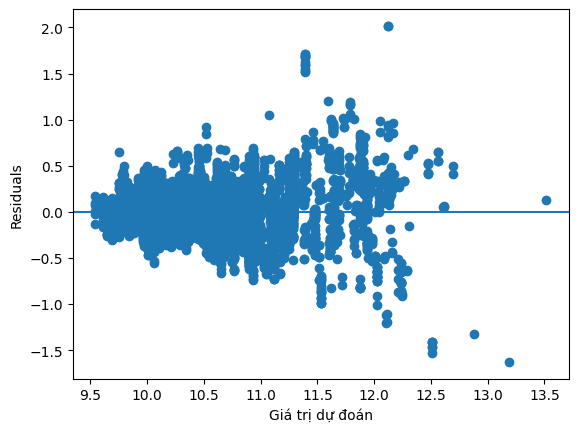

In [56]:
# Lấy fitted values và residuals
fitted = model_with_make.fittedvalues
residuals = model_with_make.resid

plt.figure()
plt.scatter(fitted, residuals)
plt.axhline(0)
plt.xlabel("Giá trị dự đoán")
plt.ylabel("Residuals")
plt.title("")
plt.show()


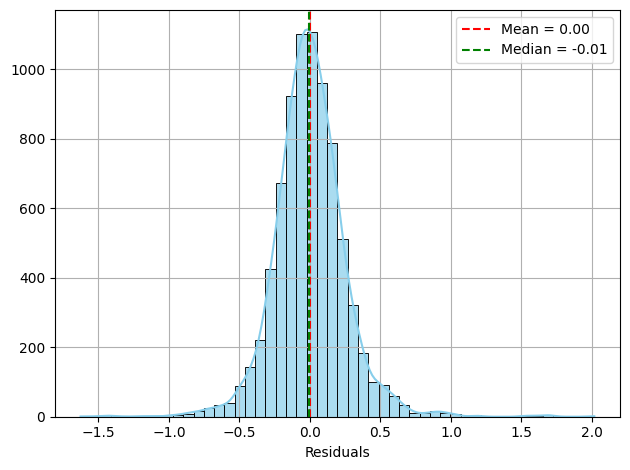

In [57]:
sns.histplot(residuals, kde=True, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean = {residuals.mean():.2f}')
plt.axvline(residuals.median(), color='green', linestyle='--', label=f'Median = {residuals.median():.2f}')
plt.title('')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('')
plt.grid()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

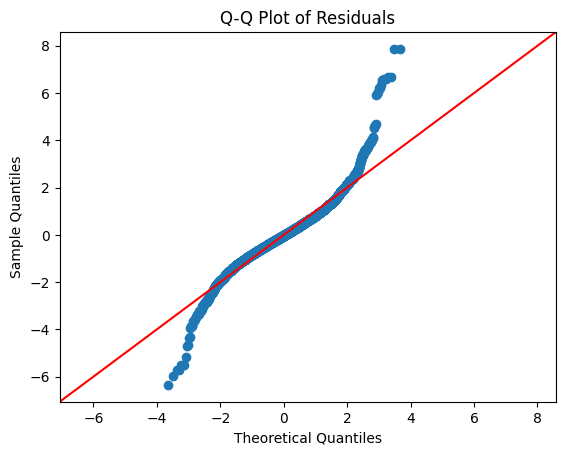

In [58]:
plt.figure()
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [59]:
# Thêm cột 1 cho hệ số chặn (intercept)
X = np.column_stack([np.ones(len(df_merged)), df_merged[['Year', 'Engine HP', 'EV', 'Hybrid']].values])
print("Ma trận X với intercept:")
print(X)
print(f"Kích thước: {X.shape}\n")


Ma trận X với intercept:
[[1.000e+00 2.011e+03 3.350e+02 0.000e+00 0.000e+00]
 [1.000e+00 2.011e+03 3.000e+02 0.000e+00 0.000e+00]
 [1.000e+00 2.011e+03 3.000e+02 0.000e+00 0.000e+00]
 ...
 [1.000e+00 2.010e+03 3.000e+01 0.000e+00 1.000e+00]
 [1.000e+00 2.017e+03 3.350e+02 0.000e+00 1.000e+00]
 [1.000e+00 2.015e+03 8.870e+02 0.000e+00 1.000e+00]]
Kích thước: (7951, 5)



In [60]:
y = df_merged['MSRP_log'].values.reshape(-1, 1)  # Chuyển thành cột (n×1)
print("Vector y (biến phụ thuộc):")
print(y)
print(f"Kích thước: {y.shape}\n")

Vector y (biến phụ thuộc):
[[10.73932716]
 [10.61275411]
 [10.50094948]
 ...
 [10.40411131]
 [11.22650926]
 [13.64709191]]
Kích thước: (7951, 1)



In [61]:
X_transpose = X.T  # Chuyển vị
X_transpose_X = np.dot(X_transpose, X)
print("X^T:")
print(X_transpose)
print("XᵀX:")
print(X_transpose_X)
print(f"Kích thước: {X_transpose_X.shape}\n")


X^T:
[[1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]
 [2.011e+03 2.011e+03 2.011e+03 ... 2.010e+03 2.017e+03 2.015e+03]
 [3.350e+02 3.000e+02 3.000e+02 ... 3.000e+01 3.350e+02 8.870e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]]
XᵀX:
[[7.95100000e+03 1.60216820e+07 2.16539600e+06 7.50000000e+01
  3.47000000e+02]
 [1.60216820e+07 3.22845562e+10 4.36344320e+09 1.51130000e+05
  6.99088000e+05]
 [2.16539600e+06 4.36344320e+09 6.92018782e+08 1.57900000e+04
  7.78440000e+04]
 [7.50000000e+01 1.51130000e+05 1.57900000e+04 7.50000000e+01
  0.00000000e+00]
 [3.47000000e+02 6.99088000e+05 7.78440000e+04 0.00000000e+00
  3.47000000e+02]]
Kích thước: (5, 5)



In [62]:
X_transpose_y = np.dot(X_transpose, y)
print("Xᵀy (5×1 vector):")
print(X_transpose_y)
print(f"Kích thước: {X_transpose_y.shape}\n")


Xᵀy (5×1 vector):
[[8.39666992e+04]
 [1.69197398e+08]
 [2.33207071e+07]
 [8.03038790e+02]
 [3.65177195e+03]]
Kích thước: (5, 1)



In [63]:
# 1. TÍNH NGHỊCH ĐẢO BẰNG np.linalg.inv() (nếu khả nghịch)
def calculate_inverse_xtx(X):
    """
    Tính (XᵀX)⁻¹ và kiểm tra điều kiện
    """
    XTX = X.T @ X
    
    # Kiểm tra tính khả nghịch
    rank = np.linalg.matrix_rank(XTX)
    n_features = XTX.shape[0]
    
    if rank < n_features:
        print(f"⚠️ CẢNH BÁO: XᵀX không khả nghịch (rank={rank} < {n_features})")
        print("Có thể do đa cộng tuyến hoàn hảo")
        return None
    
    # Tính định thức để kiểm tra
    det = np.linalg.det(XTX)
    print(f"Định thức của XᵀX: {det:.6e}")
    
    if abs(det) < 1e-10:
        print("⚠️ Định thức quá nhỏ, có thể gặp vấn đề số học")
    
    # Tính nghịch đảo
    XTX_inv = np.linalg.inv(XTX)
    return XTX_inv

# Tính nghịch đảo
XTX_inv = calculate_inverse_xtx(X)

if XTX_inv is not None:
    print("\n(XᵀX)⁻¹:")
    print(XTX_inv)
    print(f"\nKích thước (XᵀX)⁻¹: {XTX_inv.shape}")

    # Tính hệ số beta
    beta = XTX_inv @ X_transpose_y

    print("\nHệ số beta:")
    print(beta)

Định thức của XᵀX: 5.277852e+20

(XᵀX)⁻¹:
[[ 1.52450787e+02 -7.56599790e-02  3.45959619e-05  1.83138365e-03
  -2.92007858e-02]
 [-7.56599790e-02  3.75495964e-05 -1.85199977e-08 -1.06209795e-06
   1.43576172e-05]
 [ 3.45959619e-05 -1.85199977e-08  9.89615662e-09  6.39597290e-07
   4.95541661e-07]
 [ 1.83138365e-03 -1.06209795e-06  6.39597290e-07  1.35074913e-02
   1.64902006e-04]
 [-2.92007858e-02  1.43576172e-05  4.95541661e-07  1.64902006e-04
   3.04570565e-03]]

Kích thước (XᵀX)⁻¹: (5, 5)

Hệ số beta:
[[ 1.94402831e+01]
 [-5.01859617e-03]
 [ 4.48190879e-03]
 [ 4.36115448e-01]
 [ 1.88888685e-01]]
